### Image Captioning with Visual Attention

<b>Task for Vedantu Machine Learning Research Internship</b><br>
<b>Submitted By - Aniket Gupta</b>


In [29]:
# Import all the required libraries
import os
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

### Read the Dataset and feed it into a numpy array

In [30]:
# Set the dataset path and check dataset
Dataset_images_path = "/home/aniket/Deep_RL/Vedantu_Internship/Flickr8k/Flicker8k_Dataset/"
Dataset_captions_path = "/home/aniket/Deep_RL/Vedantu_Internship/Flickr8k/Flickr8k_text/Flickr8k.token.txt"

Total_images = os.listdir(Dataset_images_path)
print(f"Total images: {len(Total_images)}") 

Total images: 16182


In [31]:
# Read the dataset and feed it into a numpy array
# Reading the caption data
with open(Dataset_captions_path, 'r') as File:
    captions = File.read()

data = list()
for caption in captions.split('\n'):
    columns = caption.split('\t')
    # Remove the last line of the token text file
    if len(columns)==1:
        continue
    data.append(columns[0].split('#') + [columns[1].lower()])

datatable = np.array(data)

print(f"Total_files : {len(np.unique(datatable[:,0]))}")
print(f"Total_Captions : {len(datatable)}")
print(f"Total_Captions_per_image : {len(datatable)/len(np.unique(datatable[:,0]))}")

Total_files : 8091
Total_Captions : 40455
Total_Captions_per_image : 5.0


### Generate Vocbulary

In [32]:
# Add Start and End tokens to the captions

Vocab = list()
Captions = list()

for caption in datatable[:,2]:
    Vocab.extend(caption.split())
    Captions.append('<start> ' + caption+ ' <end>')

Vocab = list(set(Vocab))
print(f"Total_words_in_vocabulary : {len(Vocab)}")
print(f"Check captions : \n\n{Captions[0]}\n{Captions[1]}")

Total_words_in_vocabulary : 8918
Check captions : 

<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>
<start> a girl going into a wooden building . <end>


In [33]:
# Complete the image name in the numpy matrix with the full data path
Images = list()

for image in datatable[:,0]:
    Images.append(Dataset_images_path + image)

print(f"Check image paths : \n\n{Images[0]}\n{Images[1]}")

Check image paths : 

/home/aniket/Deep_RL/Vedantu_Internship/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg
/home/aniket/Deep_RL/Vedantu_Internship/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg


In [34]:
# Shuffle all the data
Train_Captions, Train_Images = shuffle(Captions,Images,random_state=1)

In [35]:
Train_Captions = Train_Captions[:40000]
Train_Images = Train_Images[:40000]

### Initiate a VGG16 model to extract image features

In [36]:
Image_model = VGG16(include_top=False, weights='imagenet')
#Feature_model = Model(Image_model.input, Image_model.layers[-1].output)
Feature_model = Model(Image_model.input, Image_model.output)

### Extract features and save them in Numpy files

In [37]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

# Get all the images
Unique_images = sorted(set(Train_Images))

Dataset = tf.data.Dataset.from_tensor_slices(Unique_images)
Dataset = Dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Shape of the dataset: {Dataset}")

Shape of the dataset: <BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


In [ ]:
for img, path in tqdm(Dataset):
    Extracted_features = Feature_model(img)
    Extracted_features = tf.reshape(Extracted_features, (Extracted_features.shape[0], -1, Extracted_features.shape[3]))
    
    for a,b in zip(Extracted_features, path):
        Feature_path = b.numpy().decode('utf-8')
        np.save(Feature_path, a.numpy())

  0%|          | 0/127 [00:00<?, ?it/s]

In [14]:
# Check this shape here
print(Extracted_features.numpy().shape)

### Preprocess and tokenize the captions

In [38]:
# Tokenize the captions
Tokenizer = tf.keras.preprocessing.text.Tokenizer(5000, oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
Tokenizer.fit_on_texts(Train_Captions)
Train_Seqeunces = Tokenizer.texts_to_sequences(Train_Captions)

Tokenizer.word_index['<pad>'] = 0
Tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
Train_Seqeunces = Tokenizer.texts_to_sequences(Train_Captions)

Captions_vector = tf.keras.preprocessing.sequence.pad_sequences(Train_Seqeunces, padding='post')

print(Captions_vector.shape)

(40000, 39)


In [39]:
print(len(Tokenizer.word_index))

8461


### Split the data into training and testing

In [40]:
# Calculates the max_length, which is used to store the attention weights
max_length = Captions_vector.shape[1]

# Create training and validation sets using an 80-20 split
Training_images, Validation_images, Training_captions, Validation_captions = train_test_split(Train_Images,Captions_vector,test_size=0.2,random_state=0)

In [41]:
# Training Parameters
Batch_size = 64
Buffer_size = 1000
Embedding_dim = 256
Units = 512
Vocab_size = len(Tokenizer.word_index) + 1
num_steps = len(Training_images) // Batch_size
Epochs = 20

features_shape = 512
attention_features_shape = 49

### Load the saved numpy files of extracted image features and generate a dataset tensor 

In [42]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

Training_dataset = tf.data.Dataset.from_tensor_slices((Training_images, Training_captions))

# Use map to load the numpy files in parallel
Training_dataset = Training_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
Training_dataset = Training_dataset.shuffle(Buffer_size).batch(Batch_size)
Training_dataset = Training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Define the CNN, RNN and Attention Models

In [43]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [44]:
class CNN(tf.keras.Model):
    def __init__(self, input_dim):
        super(CNN, self).__init__()
        self.FC = tf.keras.layers.Dense(input_dim, activation='relu')

    def call(self, x):
        return self.FC(x)

In [45]:
class RNN(tf.keras.Model):
    def __init__(self, input_dim, units, vocab_size):
        super(RNN, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, input_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = Attention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
encoder = CNN(Embedding_dim)
decoder = RNN(Embedding_dim, Units, Vocab_size)

### Define the Loss Function

In [47]:
optimizer = tf.keras.optimizers.Adam()

def Loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [48]:
# Make arrangements to get checkpoints
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### Train the Complete Model
#### Single Training step -> Forward and Backward Propogation

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([Tokenizer.word_index['<start>']] * Batch_size, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += Loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

#### Calculate total loss per epoch

In [54]:
Loss_log = []
for epoch in range(start_epoch, Epochs):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(Training_dataset)):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            temp = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch} Batch {batch} Loss {temp}')
            Loss_log.append(temp)

    if epoch % 2 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch} Loss {total_loss/num_steps}')

2it [00:16, 11.27s/it]

Epoch 3 Batch 0 Loss 0.8142802409636669


102it [00:34,  5.51it/s]

Epoch 3 Batch 100 Loss 0.851859850761218


202it [00:52,  5.48it/s]

Epoch 3 Batch 200 Loss 0.7655817667643229


302it [01:11,  5.46it/s]

Epoch 3 Batch 300 Loss 0.9149283384665464


402it [01:29,  5.31it/s]

Epoch 3 Batch 400 Loss 0.8772260225736178


500it [01:48,  4.62it/s]
0it [00:00, ?it/s]

Epoch 3 Loss 0.8371690511703491


2it [00:00,  2.32it/s]

Epoch 4 Batch 0 Loss 0.7530868236835186


102it [00:19,  5.45it/s]

Epoch 4 Batch 100 Loss 0.748649157010592


202it [00:37,  5.42it/s]

Epoch 4 Batch 200 Loss 0.7933199955866888


302it [00:56,  5.42it/s]

Epoch 4 Batch 300 Loss 0.8302606435922476


402it [01:14,  5.38it/s]

Epoch 4 Batch 400 Loss 0.8383998381785858


500it [01:33,  5.37it/s]
0it [00:00, ?it/s]

Epoch 4 Loss 0.7800048589706421


2it [00:00,  2.34it/s]

Epoch 5 Batch 0 Loss 0.7267501537616436


102it [00:19,  5.36it/s]

Epoch 5 Batch 100 Loss 0.7270560631385217


202it [00:37,  5.44it/s]

Epoch 5 Batch 200 Loss 0.685908684363732


302it [00:56,  5.48it/s]

Epoch 5 Batch 300 Loss 0.7681738535563151


402it [01:14,  5.22it/s]

Epoch 5 Batch 400 Loss 0.7408876174535507


500it [01:33,  5.37it/s]
0it [00:00, ?it/s]

Epoch 5 Loss 0.7321690917015076


2it [00:00,  2.27it/s]

Epoch 6 Batch 0 Loss 0.6485471480931991


102it [00:19,  5.39it/s]

Epoch 6 Batch 100 Loss 0.7116985810108674


202it [00:38,  5.05it/s]

Epoch 6 Batch 200 Loss 0.6942172417273889


302it [00:56,  5.40it/s]

Epoch 6 Batch 300 Loss 0.7898852030436198


402it [01:15,  5.31it/s]

Epoch 6 Batch 400 Loss 0.6887312669020432


475it [01:29,  5.31it/s]


KeyboardInterrupt: 

#### Plot the Loss Values

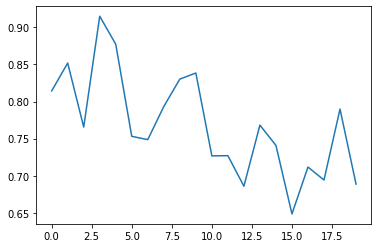

In [72]:
plt.plot(Loss_log)

### Evaluate the trained model on random images from the validation set

In [55]:
def Evaluate(image):
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = Feature_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([Tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(Tokenizer.index_word[predicted_id])
        
        if Tokenizer.index_word[predicted_id] == '<end>':
            return result
        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [60]:
from IPython.display import display, Image

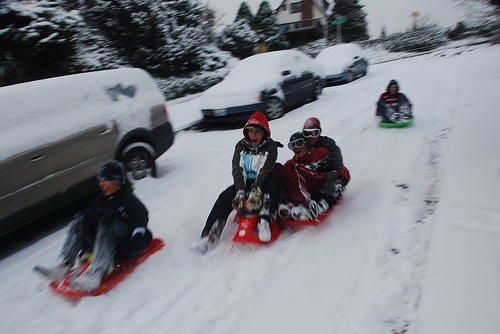

True Caption: <start> children are sledding down a snowy hill <end>
Prediction Caption:  two people ride down a hill <end>


In [71]:
# Get a random image
Image_id = np.random.randint(0, len(Validation_images))
image = Validation_images[Image_id]

# Plot the image
display(Image(filename=image))

True_Caption = ' '.join([Tokenizer.index_word[i] for i in Validation_captions[Image_id] if i not in [0]])
Result = Evaluate(image)

for i in Result:
    if i=="<unk>":
        Result.remove(i)

print ('True Caption:', True_Caption)
print ('Prediction Caption: ', ' '.join(Result))